In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [34]:
def show_image(image, label=''):
    if len(image.shape) > 2:
        image = image[..., ::-1]
    plt.imshow(image, label=label)
    plt.axis('off')
def show_images(images, labels, figsize=(16, 16)):
    plt.figure(figsize=figsize)
    for i in range(len(images)):
        plt.subplot(2, 2, i + 1)
        show_image(images[i], label=labels[i])
    
    plt.tight_layout()
    plt.show()

In [40]:
def compute_area(image_path, min_area=10000):
    # Đọc ảnh
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # 1. Phân vùng lá cây
    lower_green = np.array([35, 40, 50])
    upper_green = np.array([85, 255, 255])
    leaf_mask = cv2.inRange(hsv, lower_green, upper_green)
    leaf_mask = cv2.medianBlur(leaf_mask, 5)

    # Tìm tất cả contours (bao gồm cả contour trong và ngoài)
    contours, hierarchy = cv2.findContours(leaf_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # 2. Phát hiện đồng xu
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                            param1=50, param2=30, minRadius=10, maxRadius=50)

    # 3. Tính toán diện tích với vùng trống
    result = image.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))
        coin = circles[0][0]
        coin_diameter_px = coin[2] * 2
        coin_diameter_mm = 21.25
        scale = coin_diameter_mm / coin_diameter_px

        # Vẽ contour trước
        cv2.drawContours(result, contours, -1, (0, 0, 255), 2, hierarchy=hierarchy)  # Vẽ tất cả contour
        cv2.circle(result, (coin[0], coin[1]), coin[2], (0, 255, 0), 2)  # Đồng xu

        # Danh sách lưu diện tích và nhãn
        leaf_areas = []
        processed = set()  # Để tránh xử lý lại contour đã tính

        # Duyệt qua các contour cấp ngoài (external)
        for i in range(len(contours)):
            if i in processed or hierarchy[0][i][3] != -1:  # Bỏ qua contour không phải cấp ngoài
                continue
            
            # Diện tích contour ngoài
            outer_area_px = cv2.contourArea(contours[i])
            if outer_area_px < min_area:
                continue

            # Tìm tất cả contour trong (nếu có)
            inner_area_px = 0
            child_idx = hierarchy[0][i][2]  # Chỉ số contour con đầu tiên
            while child_idx != -1:
                inner_area_px += cv2.contourArea(contours[child_idx])
                processed.add(child_idx)
                child_idx = hierarchy[0][child_idx][0]  # Chuyển sang contour con tiếp theo

            # Diện tích thực tế = ngoài - trong
            true_area_px = outer_area_px - inner_area_px
            true_area_mm2 = true_area_px * (scale ** 2)
            leaf_areas.append((i, true_area_mm2))

            # Tính tâm của contour ngoài
            M = cv2.moments(contours[i])
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                cv2.putText(result, f"L{i}", (cX - 10, cY), cv2.FONT_HERSHEY_SIMPLEX, 
                            0.6, (255, 255, 0), 2)  # Vẽ text sau cùng

        # In kết quả
        print("Area of each leaves (Except empty regions):")
        for label, area in leaf_areas:
            print(f".extendLeaf {label}: {area:.2f} mm²")
            
        images = [image, hsv, result, leaf_mask]
        labels = ['Original', 'HSV', 'Result', 'Mask']
        
        show_images(images, labels)

Area of each leaves (Except empty regions):
.extendLeaf 6: 3911.07 mm²
.extendLeaf 11: 8258.17 mm²
.extendLeaf 28: 10885.46 mm²


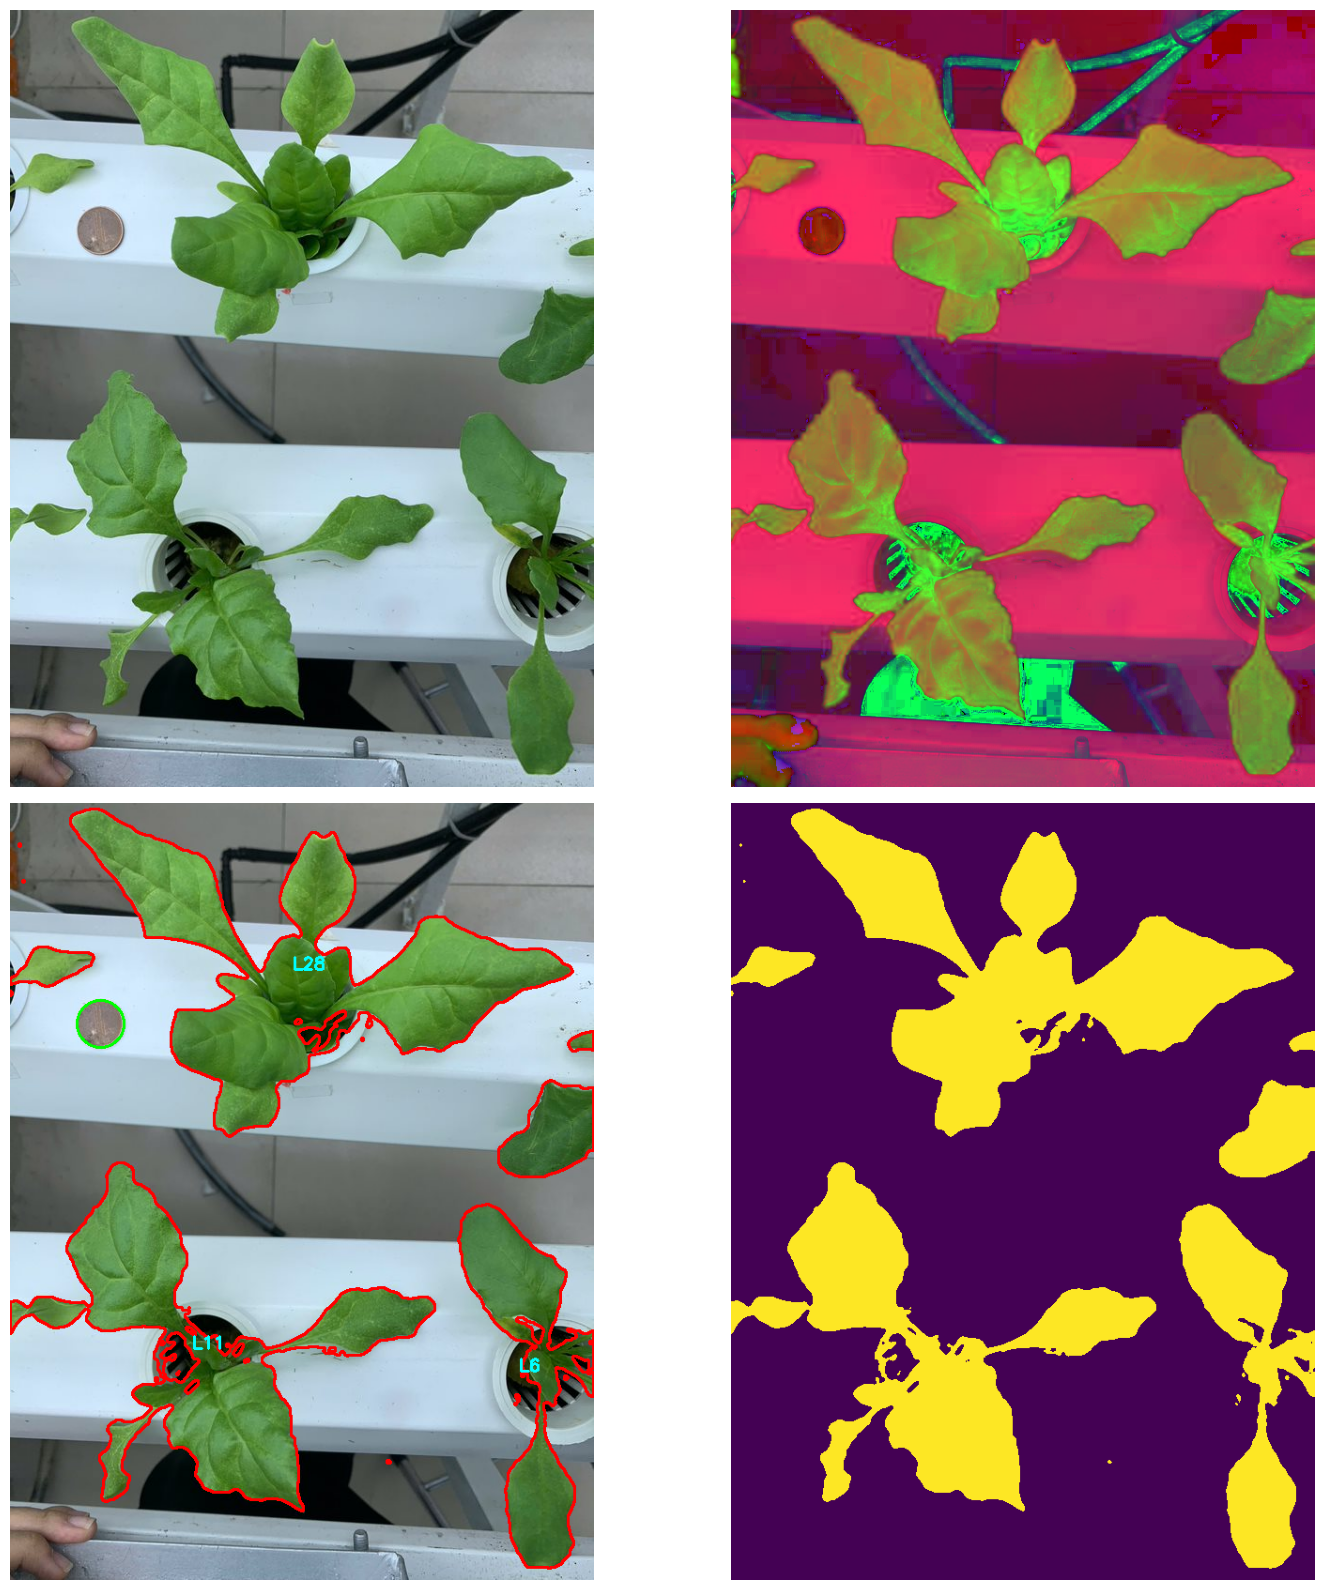

In [41]:
image_path = 'im.jpg'
compute_area(image_path)

Area of each leaves (Except empty regions):
.extendLeaf 45: 2740.60 mm²
.extendLeaf 86: 769.43 mm²
.extendLeaf 104: 1780.91 mm²
.extendLeaf 181: 37935.34 mm²
.extendLeaf 388: 968.22 mm²
.extendLeaf 402: 1474.23 mm²
.extendLeaf 412: 602.09 mm²
.extendLeaf 435: 968.25 mm²
.extendLeaf 439: 4362.25 mm²


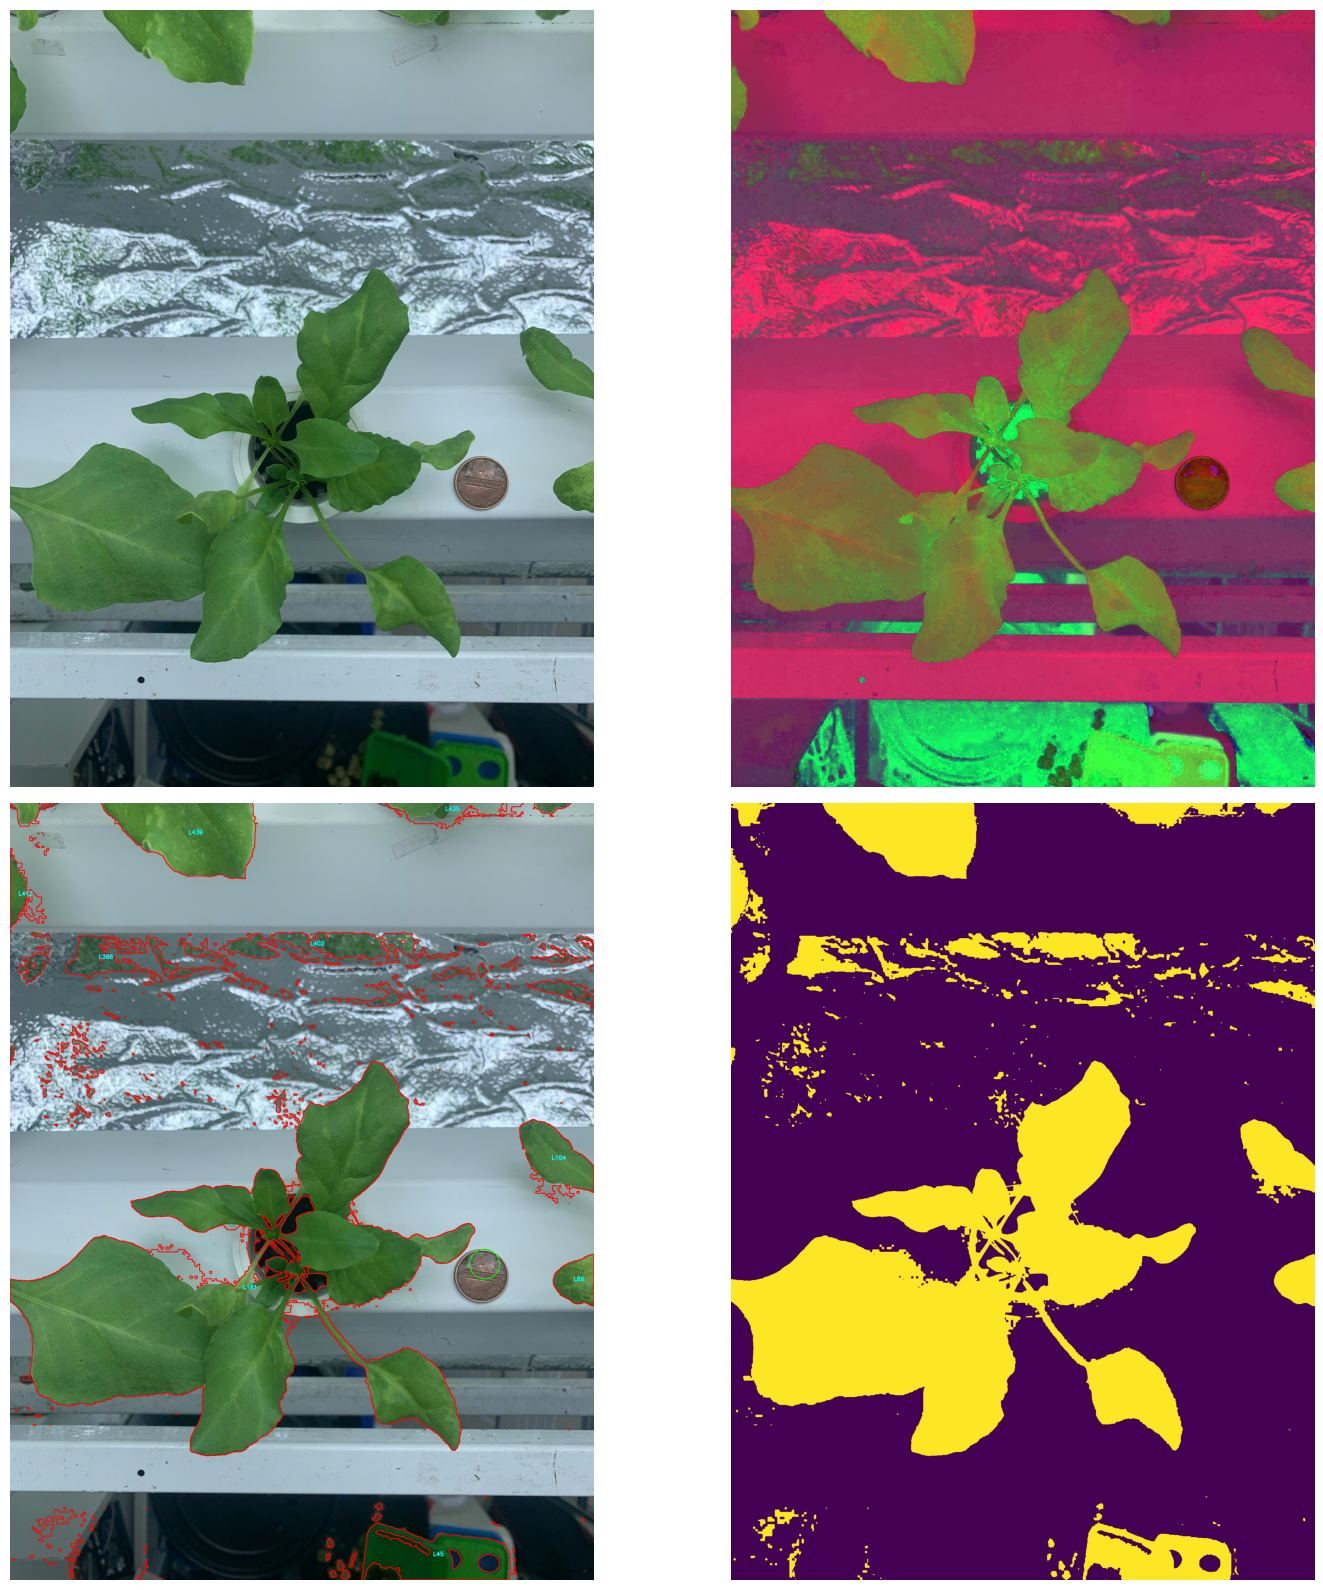

In [42]:
image_path = 'data/X2/3.X2.1.6.153.11012025.jpg'
compute_area(image_path)